In [69]:
from glob import glob
import os
import csv

import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np


In [83]:
def saver(root, fig_path, area, perimeter, fb, cutThreshold, indexCell, fig, mask, indexImg):
    result_main = os.path.join(root,"results")

    if not os.path.exists(result_main):
        os.makedirs(result_main)

    parts = os.path.split(fig_path)[0].split(os.sep)
    cell_line = parts[1]
    time = parts[2]
    save_folder = os.path.join(result_main,os.path.join(cell_line,time))

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    path_csv = os.path.join(result_main,"results.csv")

    if not os.path.exists(path_csv):
        with open(path_csv,mode = 'w', newline = "") as f:
            writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(["name", "area(pixel)", "perimeter(pixel)", "x_1", "y_1", "x_2", "y_2", "figPath",  "cutThreshold", "index_cell"])

    name = os.path.join(save_folder,"contour_img_{}_cell_{}.npy".format(indexImg, indexCell))
    name_figure = os.path.join(save_folder,"contour_img_{}_cell_{}.png".format(indexImg, indexCell))

    with open(path_csv,mode = 'a', newline = "") as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name, area, perimeter, int(fb[0][0][0]),int(fb[0][0][1]),int(fb[0][1][0]),int(fb[0][1][1]), fig_path, cutThreshold, indexCell]) 

    np.save(name, mask)
    fig.savefig(name_figure)
    

def increase_brightness(img, value=1):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def faridFilter(img, filterCoef):

    def mousePoints(event,x,y,flags,param):
        #Crop image
        global refPt
        global image
        # Left button click
        if event == cv2.EVENT_LBUTTONDOWN:
            refPt = [(x, y)]
        elif event == cv2.EVENT_LBUTTONUP:
            refPt.append((x, y))
            final_boundaries.append((refPt[0],refPt[1]))
            #cv2.rectangle(frame, refPt[0], refPt[1], (0, 255, 0), 25)
            cv2.imshow("win", frame)
        elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
            clone = frame.copy()
            cv2.rectangle(clone, refPt[0], (x, y), (0, 255, 0), 25)
            cv2.imshow("win", clone)

    fig, ax = plt.subplots(1, 2,figsize=(10, 5))

    #img = increase_brightness(cv2.imread(figs[indexImg]))
    frame = img.copy()

    #global final_boundaries
    final_boundaries = []

    cv2.namedWindow('win',cv2.WINDOW_NORMAL)
    cv2.setMouseCallback("win", mousePoints)

    cv2.imshow("win",frame)

    k = cv2.waitKey(0)       
    # Destroying present windows on screen
    cv2.destroyAllWindows()

    crop = frame[final_boundaries[0][0][1]:final_boundaries[0][1][1],final_boundaries[0][0][0]:final_boundaries[0][1][0],:]

    yabs = int(np.abs(final_boundaries[0][0][1]-final_boundaries[0][1][1])/2)
    xabs = int(np.abs(final_boundaries[0][0][0]-final_boundaries[0][1][0])/2)

    ax[0].set_title("Cropped image")
    ax[0].imshow(crop)

    cropBW = skimage.color.rgb2gray(crop)

    g = skimage.filters.gaussian(cropBW,filterCoef)
    #g = skimage.filters.butterworth((g), order = 1,high_pass = False)

    edges = skimage.filters.farid(g)

    ax[1].set_title("after filter")

    im1 = ax[1].imshow(1-edges, cmap = "inferno")
    plt.colorbar(mappable = im1)

    plt.show()

    return edges, final_boundaries

def segmentImg(img, edges, final_boundaries, cutThreshold, idx):
    ClosingCoef = 15
    whiteTopCoef = 5
    dilationCoedf = 5

    frame = img.copy()
    
    e = 1-edges<cutThreshold

    e = skimage.morphology.closing(e, skimage.morphology.disk(ClosingCoef))
    e2 = skimage.morphology.white_tophat(e,skimage.morphology.disk(whiteTopCoef))
    e2 = skimage.morphology.dilation(e2,skimage.morphology.disk(dilationCoedf))

    tmp = e.astype("int")-e2.astype("int")
    tmp[tmp<0] = 0
    tmp = tmp.astype("uint8")

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=tmp, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)                          

    # draw contours on the original image
    image_copy = np.zeros_like(frame[:,:,0].copy())
    areas = [cv2.contourArea(c) for c in contours]

    largest_idx = np.argmin(np.abs(np.array(sorted(areas)[idx])-areas))
    largest = contours[largest_idx]
    
    perimeter =  cv2.arcLength(largest,True)

    area = cv2.contourArea(largest)

    for i in range(len(largest[:])):
        largest[i][0][0] += final_boundaries[0][0][0] #xabs
        largest[i][0][1] += final_boundaries[0][0][1] #yabs

    cv2.fillPoly(image_copy, pts = [largest], color=(255,255,255))

    col = np.zeros_like(frame[:,:,0])
    col[image_copy.astype("bool")] = 255.
    mask = np.zeros_like(frame)
    mask[col.astype("bool"),2] = 255.
    out = cv2.addWeighted(frame,0.95,mask,10,0.)

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=col, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(image=frame, contours=[largest], contourIdx=-1, color=255, thickness=3)


    fig, ax = plt.subplots(2, 2,figsize=(15, 10), facecolor='white')

    ax[0,0].imshow(frame)
    ax[0,1].imshow(mask)
    ax[1,0].imshow(out)
    ax[1,1].imshow(frame[final_boundaries[0][0][1]:final_boundaries[0][1][1],final_boundaries[0][0][0]:final_boundaries[0][1][0],:])

    return fig, area, perimeter, largest, mask

In [71]:
root = "C:/Users/lehtona6/Experiments/ImageAnalysis/collagen_spheroids/230719_2mgml_2500cellsml"
figs = glob(os.path.join(root,"*/*/*.tif"))

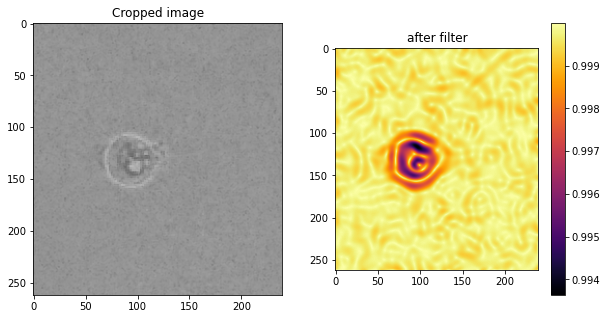

In [79]:
#index of analae 6
indexImg = 0 #index of image
indexCell = 0

fig_path = figs[indexImg]

currentFrame = cv2.imread(fig_path)
edges, final_boundaries = faridFilter(currentFrame, filterCoef=5)


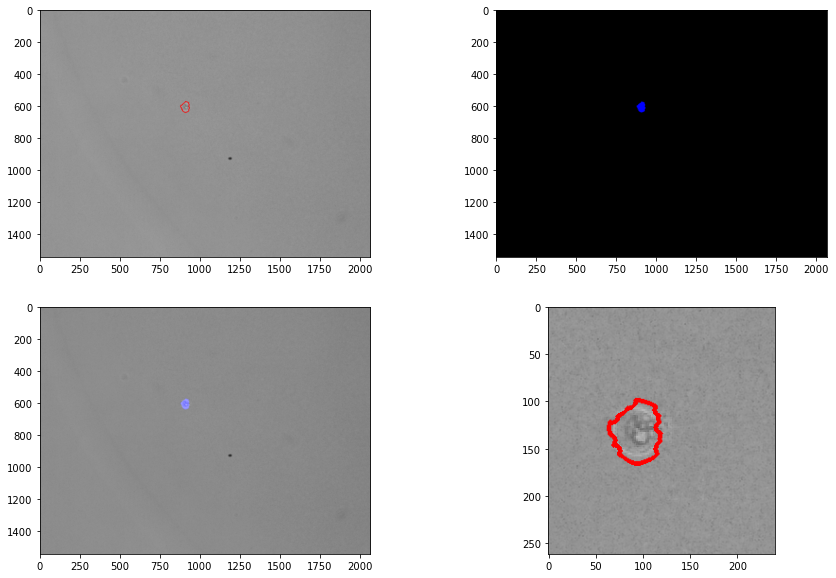

In [80]:
cutThreshold = 99.8e-2
fig, area, perimeter, largest, mask = segmentImg(currentFrame, edges, final_boundaries, cutThreshold, -1)

In [84]:
saver(root, fig_path, area, perimeter, final_boundaries, cutThreshold, indexCell, fig, mask, indexImg)